### 多级模型 Multi-level models（变化的截距和斜率）
***
这是一个如何使用 python 和 `pymer4` 包拟合 MLM 模型的示例。Pymer4 是 R 中著名的 `lme4` 包的 python 版本，其文档可在以下位置找到：https://eshinjolly.com/pymer4/


In [1]:
#pip install pymer4

In [2]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import libpysal as ps
from libpysal.weights import Queen
from esda.moran import Moran

from pymer4.models import Lmer

我们将使用相同的投票数据来证明 MLM。

In [3]:
voting = pd.read_csv('https://raw.github.com/Ziqi-Li/gis5122/master/data/voting_2020_with_gov.csv')

#voting[['median_income']] = voting[['median_income']]/10000

In [4]:
shp = gpd.read_file("https://raw.github.com/Ziqi-Li/gis5122/master/data/us_counties.geojson")

In [5]:
#Merge the shapefile with the voting data by the common county_id
shp_voting = shp.merge(voting, on ="county_id")

#Dissolve the counties to obtain boundary of states, used for mapping
state = shp_voting.dissolve(by='STATEFP')

### 拟合 MLM 模型（根据州改变截距和斜率）

In [6]:
warnings.filterwarnings('ignore')

model_all_states = Lmer('new_pct_dem ~ 1 + pct_bach + (1 + pct_bach | state)', data=shp_voting)

model_all_states.fit()

Model failed to converge with max|grad| = 0.129117 (tol = 0.002, component 1) 

Linear mixed model fit by REML [’lmerMod’]
Formula: new_pct_dem~1+pct_bach+(1+pct_bach|state)

Family: gaussian	 Inference: parametric

Number of observations: 3102	 Groups: {'state': 47.0}

Log-likelihood: -12037.964 	 AIC: 24087.929

Random effects:

                 Name      Var     Std
state     (Intercept)  119.701  10.941
state        pct_bach    0.076   0.276
Residual               128.334  11.328

               IV1       IV2   Corr
state  (Intercept)  pct_bach -0.641

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)    18.327  14.825   21.830  1.787  42.611  10.256    0.0  ***
pct_bach        0.791   0.693    0.888  0.050  42.962  15.852    0.0  ***

模型 AIC

In [7]:
model_all_states.AIC

24087.928602917116

边际 R2：描述仅由固定因素解释的方差比例

条件 R2：描述由固定和随机因素解释的方差比例

来自 Nakagawa 和 Schielzeth (2012) [链接](https://besjournals.onlinelibrary.wiley.com/doi/10.1111/j.2041-210x.2012.00261.x)

In [8]:
def r_square(model):
    var_a = np.sum(model.ranef_var.Var[:-1]) #Sum of variances from random effects
    var_e = model_all_states.ranef_var.Var[-1] #Error variance 
    var_f = np.sum(model.design_matrix*model.coefs.Estimate,axis=1).var() #Sum of variances from fixed effects
    
    marginal = var_f/(var_f+var_a+var_e)
    
    conditional = (var_f+var_a)/(var_f+var_a+var_e)
    
    print("marginal R2:",marginal)
    print("conditional R2:",conditional)
    return

In [9]:
r_square(model_all_states)

marginal R2: 0.18633369427772392
conditional R2: 0.5791354545442352


我们还可以看到随机效应的分布，它们应该是从多元正态分布中得出的，截距的方差为 119.701，pct_bach 的方差为 0.076，相关性为 -0.641。

array([[<Axes: title={'center': 'X.Intercept.'}>,
        <Axes: title={'center': 'pct_bach'}>]], dtype=object)

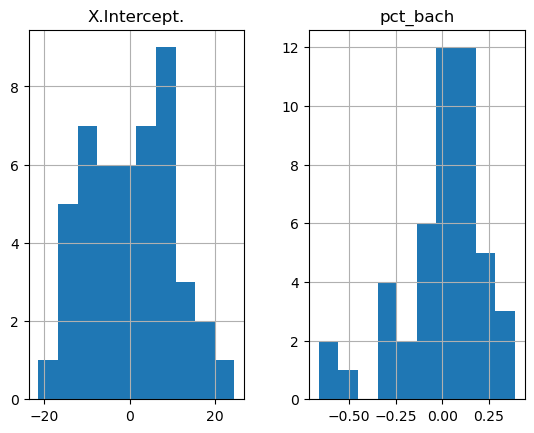

In [10]:
model_all_states.ranef.hist()

Text(0, 0.5, 'Random effect of pct_bach')

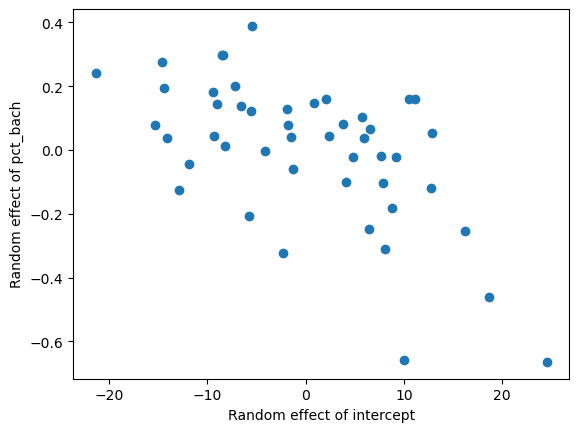

In [11]:
plt.scatter(model_all_states.ranef.iloc[:,0], model_all_states.ranef.iloc[:,1])
plt.xlabel("Random effect of intercept")
plt.ylabel("Random effect of pct_bach")

负相关表示，当截距较大时，各州的斜率较小（较平坦）。


如果我们绘制随机效应图来显示每个状态如何偏离整体效应，则图将如下所示：

Text(0.5, 1.0, 'Varying intercept')

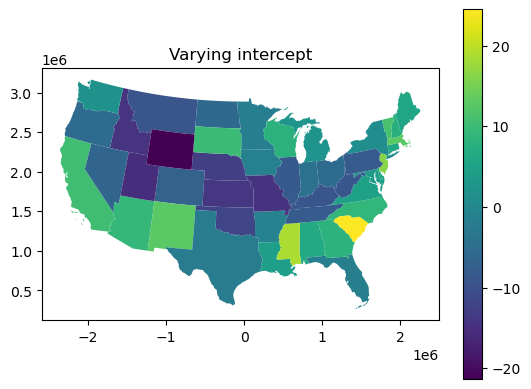

In [12]:
state.plot(model_all_states.ranef.iloc[:,0].values,legend=True)
plt.title("Varying intercept")

Text(0.5, 1.0, 'Varying slope of pct_bach')

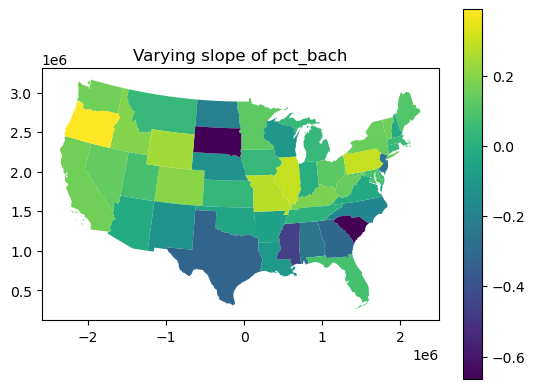

In [13]:
state.plot(model_all_states.ranef.iloc[:,1].values,legend=True)
plt.title("Varying slope of pct_bach")

随机效应再次向我们展示了与固定效应的偏差。
您还可以添加固定效应估计值以获得总效应图（固定 + 随机）。
也就是说，为截距图添加 18.327，为巴赫图添加 0.791。

### 效果的置信区间（固定和随机）

In [14]:
model_all_states.confint(method='boot', level=0.95, nsim=1000)

Computing bootstrap confidence intervals ...


91 warning(s): Model failed to converge with max|grad| = 0.00200431 (tol = 0.002, component 1) (and others)




2.5 %     97.5 %
sd_(Intercept)|state             8.013204  13.574314
cor_pct_bach.(Intercept)|state  -0.823212  -0.339756
sd_pct_bach|state                0.195109   0.358206
sigma                           11.054547  11.600071
(Intercept)                     14.861046  22.092519
pct_bach                         0.681197   0.886333

它们都具有统计学意义，95% 置信区间不包括零。

但是，如果任何置信区间包含零，则它在统计学上不显著。

如果随机效应不显著，则意味着各组之间没有差异。

如果固定效应不显著，则意味着它对因变量没有全局影响。